# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform.

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page. Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view). **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations.

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>

At the end of the notebook, you will find directions for how to submit your work. Let's get started by importing the necessary libraries and reading in the data.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import re
from subprocess import call

from copy import deepcopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from typing import Iterable, Callable, Tuple
from pathlib import Path
from IPython import display as ICD
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

In [3]:
src_path: str = "../src"
sys.path.append(src_path)


In [4]:
import tests.project_tests as t


In [5]:
data_root: Path = Path("../data")


In [6]:
df = pd.read_csv(
    data_root.joinpath("user_item_interactions.csv"),
    dtype={"article_id": int},
)
df_content = pd.read_csv(
    data_root.joinpath("articles_community.csv"),
    dtype={"article_id": int},
)

print(f"User-item interactions dataset {df.shape}:")
ICD.display(df.head())

print(f"Articles community dataset {df_content.shape}:")
ICD.display(df_content.head())


User-item interactions dataset (45993, 3):


,article_id,title,email
0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


Articles community dataset (1056, 5):


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset? Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.


Text(0.5, 0, 'Log2(Number of articles)')

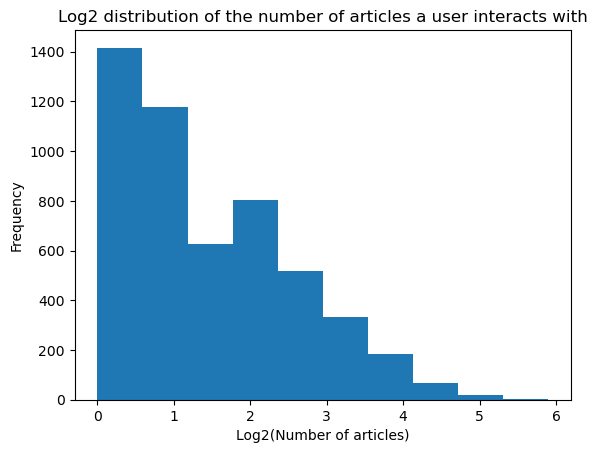

In [7]:
user_article_counts = df.groupby("email")["article_id"].count().sort_values()

np.log(user_article_counts).plot(kind="hist")
plt.title("Log2 distribution of the number of articles a user interacts with")
plt.xlabel("Log2(Number of articles)")


In [8]:
median_val = user_article_counts.median()
print(f"50% of individuals interact with {median_val:.2f} number of articles or fewer")
max_views_by_user = user_article_counts.max()
print(
    "The maximum number of user-article interactions by any 1 user is"
    f" {max_views_by_user:.2f}."
)


50% of individuals interact with 3.00 number of articles or fewer
The maximum number of user-article interactions by any 1 user is 364.00.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.


In [9]:
# Find and explore duplicate articles
df_content[df_content.duplicated(subset=["article_id"])]


,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [10]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=["article_id"])


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.


In [11]:
unique_articles = df["article_id"].nunique()
print(
    f"Number of unique articles that have at least one interaction: {unique_articles}"
)

total_articles = df_content[
    "article_id"
].nunique()  # The number of unique articles on the IBM platform
print(f"Number of unique articles on the IBM platform: {total_articles}")

unique_users = df["email"].nunique()
print(f"Number of unique users: {unique_users}")

user_article_interactions = len(df)
print(f"Number of user-article interactions: {user_article_interactions}")


Number of unique articles that have at least one interaction: 714
Number of unique articles on the IBM platform: 1051
Number of unique users: 5148
Number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed. After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids. There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).


In [12]:
views_per_article = df.groupby("article_id")["email"].count().sort_values()


In [13]:
most_viewed_article_id = str(views_per_article.index[-1])
print(f"The most viewed article in the dataset: {most_viewed_article_id}")

max_views = views_per_article.iloc[-1]
print(f"The most viewed article in the dataset was viewed {max_views} times.")


The most viewed article in the dataset: 1429
The most viewed article in the dataset was viewed 937 times.


In [14]:
def email_mapper(df: pd.DataFrame, email_col: str = "email") -> Iterable[int]:
    """Map email column to unique user IDs.

    Args:
        df: Dataframe whose email column to map.
        email_col: Email column to map.

    Returns:
        Decoded list of user IDs.
    """
    user_id_map = {
        v: k
        for k, v in dict(
            enumerate(df[email_col].drop_duplicates(keep="first").tolist(), start=1)
        ).items()
    }
    return df[email_col].map(user_id_map)


In [15]:
df["user_id"] = email_mapper(df, "email")
df = df.drop(columns=["email"])

# show header
ICD.display(df.head())


,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [16]:
sol_1_dict = {
    "`50% of individuals have _____ or fewer interactions.`": median_val,
    "`The total number of user-article interactions in the dataset is ______.`": user_article_interactions,
    "`The maximum number of user-article interactions by any 1 user is ______.`": max_views_by_user,
    "`The most viewed article in the dataset was viewed _____ times.`": max_views,
    "`The article_id of the most viewed article is ______.`": most_viewed_article_id,
    "`The number of unique articles that have at least 1 rating ______.`": unique_articles,
    "`The number of unique users in the dataset is ______`": unique_users,
    "`The number of unique articles on the IBM platform`": total_articles,
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)


It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not. We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.


In [17]:
def get_top_articles(df: pd.DataFrame, n: int = 10) -> Iterable[str]:
    """
    Return top articles titles by popularity (how often it has been interacted with).

    Args:
        df: Dataframe containing article-user interactions.
        n: Number of top articles to return.

    Returns:
        A list of the top 'n' article titles
    """
    # Your code here
    return df.groupby("title").count().iloc[:, 0].sort_values().iloc[-n:].index.tolist()


def get_top_article_ids(df: pd.DataFrame, n: int = 10) -> Iterable[str]:
    """
    Return top articles IDs by popularity (how often it has been interacted with).

    Args:
        df: Dataframe containing article-user interactions.
        n: Number of top articles to return.

    Returns:
        A list of the top 'n' article IDs
    """
    return (
        df.groupby("article_id")
        .count()
        .iloc[:, 0]
        .sort_values()
        .iloc[-n:]
        .index.tolist()
    )


In [18]:
print(get_top_articles(df, 10))
print(get_top_article_ids(df, 10))


['gosales transactions for logistic regression model', 'analyze energy consumption in buildings', 'apache spark lab, part 1: basic concepts', 'finding optimal locations of new store using decision optimization', 'healthcare python streaming application demo', 'predicting churn with the spss random tree algorithm', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'visualize car data with brunel', 'insights from new york car accident reports', 'use deep learning for image classification']
[1304, 1162, 1170, 1293, 1314, 1364, 1427, 1431, 1330, 1429]


In [19]:
# Test each of your three lists from above
t.sol_2_test(get_top_articles)


Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.

- Each **user** should only appear in each **row** once.

- Each **article** should only show up in one **column**.

- **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**. It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.

- **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**.

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.


In [20]:
def create_user_item_matrix(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a matrix with user ids as rows and article ids on the columns with
        1 values where a user interacted with an article and a 0 otherwise

    Args:
        df: pandas dataframe with article_id, title, user_id columns

    Returns:
        A user-item matrix

    """
    return pd.crosstab(df["user_id"], df["article_id"]).astype(bool).astype(int)


In [21]:
user_item = create_user_item_matrix(df)


In [22]:
## Tests: You should just need to run this cell.  Don't change the code.
assert (
    user_item.shape[0] == 5149
), "Oops!  The number of users in the user-article matrix doesn't look right."
assert (
    user_item.shape[1] == 714
), "Oops!  The number of articles in the user-article matrix doesn't look right."
assert (
    user_item.sum(axis=1)[1] == 36
), "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")


You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar). The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.

Use the tests to test your function.


In [23]:
def find_similar_users(user_id: int, user_item: pd.DataFrame) -> Iterable[int]:
    """Find the most similar users to a given one in the user-item matrix. Computes the
        similarity of every pair of users based on the dot product.

    Args:
        user_id: User ID to compare to the rest.
        user_item: User-item dataframe.

    Returns:
        An ordered list where the closest users (largest dot product users) are listed
            first.
    """
    return (
        user_item.loc[user_id]
        .dot(user_item.transpose())
        .sort_values(ascending=False)
        .drop(user_id, axis="index")
        .index.tolist()
    )


In [24]:
# Do a spot check of your function
print(
    "The 10 most similar users to user 1 are: {}".format(
        find_similar_users(1, user_item)[:10]
    )
)
print(
    "The 5 most similar users to user 3933 are: {}".format(
        find_similar_users(3933, user_item)[:5]
    )
)
print(
    "The 3 most similar users to user 46 are: {}".format(
        find_similar_users(46, user_item)[:3]
    )
)


The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend. Complete the functions below to return the articles you would recommend to each user.


In [25]:
def get_article_names(article_ids: Iterable[int], df: pd.DataFrame) -> Iterable[str]:
    """Given a list of article IDs, get their names (titles).

    Args:
        article_ids: A list of article IDs.
        df: pandas dataframe with article_id, title, user_id columns

    Returns:
        A list of article names associated with the list of article ids (this is
            identified by the title column)
    """
    return (
        df.set_index("article_id").loc[article_ids, "title"].drop_duplicates().tolist()
    )


def get_user_articles(
    user_id: int, user_item: pd.DataFrame, df: pd.DataFrame
) -> Tuple[Iterable[int], Iterable[str]]:
    """Provides a list of the article_ids and article titles that have been seen by a
        user.

    Args:
        user_id: A user ID.
        user_item: Matrix of users by articles: 1's when a user has interacted with an
            article, 0 otherwise
        df: pandas dataframe with article_id, title, user_id columns

    Returns:
        - A list of the article ids seen by the user.
        - A list of article names associated with the list of article ids.
    """
    if user_id not in user_item.index:
        return [], []

    article_ids = user_item.columns[user_item.loc[user_id] == 1].tolist()
    return article_ids, get_article_names(article_ids, df)


def user_user_recs(
    user_id: int, user_item: pd.DataFrame, df: pd.DataFrame, m: int = 10
) -> Iterable[str]:
    """Loops through the users based on closeness to the input user_id
        For each user - finds articles the user hasn't seen before and provides them as
        recs. Does this until m recommendations are found.

    Notes:
        Users who are the same closeness are chosen arbitrarily as the 'next' user.

        For the user where the number of recommended articles starts below m
        and ends exceeding m, the last items are chosen arbitrarily.

    Args:
        user_id: A user ID.
        user_item: Matrix of users by articles: 1's when a user has interacted with an
            article, 0 otherwise
        df: pandas dataframe with article_id, title, user_id columns
        m: the number of recommendations you want for the user

    OUTPUT:
        A list of recommendations for the user.
    """
    # 1. Get closest users
    closest_users = find_similar_users(user_id, user_item)

    # 2. Loop through closest users to find up to M recommendations
    recs = []
    user_articles_ids = get_user_articles(user_id, user_item, df)[0]
    for similar_user in closest_users:
        distinct_articles = [
            article_id
            for article_id in get_user_articles(similar_user, user_item, df)[0]
            if article_id not in user_articles_ids + recs
        ]
        recs.extend(distinct_articles[: min(len(distinct_articles), m - len(recs))])

        if len(recs) >= m:
            return recs


In [26]:
# Return 10 recommendations for user 1
get_article_names(user_user_recs(1, user_item, df, 10), df)


['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [27]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427], df)) == set(
    [
        "using deep learning to reconstruct high-resolution audio",
        "build a python app on the streaming analytics service",
        "gosales transactions for naive bayes model",
        "healthcare python streaming application demo",
        "use r dataframes & ibm watson natural language understanding",
        "use xgboost, scikit-learn & ibm watson machine learning apis",
    ]
), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844], df)) == set(
    [
        "housing (2015): united states demographic measures",
        "self-service data preparation with ibm data refinery",
        "use the cloudant-spark connector in python notebook",
    ]
), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20, user_item, df)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20, user_item, df)[1]) == set(
    [
        "housing (2015): united states demographic measures",
        "self-service data preparation with ibm data refinery",
        "use the cloudant-spark connector in python notebook",
    ]
)
assert set(get_user_articles(2, user_item, df)[0]) == set(
    [1024, 1176, 1305, 1314, 1422, 1427]
)
assert set(get_user_articles(2, user_item, df)[1]) == set(
    [
        "using deep learning to reconstruct high-resolution audio",
        "build a python app on the streaming analytics service",
        "gosales transactions for naive bayes model",
        "healthcare python streaming application demo",
        "use r dataframes & ibm watson natural language understanding",
        "use xgboost, scikit-learn & ibm watson machine learning apis",
    ]
)
print("If this is all you see, you passed all of our tests!  Nice job!")


If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.

- Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.

- Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the **top_articles** function you wrote earlier.


In [28]:
from typing import Tuple


def get_top_sorted_users(
    user_id: int, df: pd.DataFrame, user_item: pd.DataFrame
) -> pd.DataFrame:
    """Generate neighbour dataframe with the following information:
        - neighbor_id - is a neighbor user_id
        - similarity - measure of the similarity of each user to the provided user_id.
        - num_interactions - the number of articles viewed by the user.

    Sort the neighbors_df by the similarity and then by number of interactions where
        highest of each is higher in the dataframe.

    Args:
        user_id: User ID.
        df: pandas dataframe with article_id, title, user_id columns.
        user_item: Matrix of users by articles: 1's when a user has interacted with an
            article, 0 otherwise.

    Returns:
        Neighbours dataframe.
    """
    # 1. Get similarity with other users (based on dot product)
    neighbors_df = (
        user_item.loc[user_id]
        .dot(user_item.transpose())
        .sort_values(ascending=False)
        .drop(user_id, axis="index")
        .rename("similarity")
        .rename_axis("neighbor_id")
        .to_frame()
    )

    # 2. Add number of interactions per neighbor
    neighbors_df["num_interactions"] = (
        df.groupby("user_id").count().iloc[:, 0].loc[neighbors_df.index]
    )

    # 3. Sort by similarity and interactions
    neighbors_df = neighbors_df.sort_values(
        ["similarity", "num_interactions"], ascending=False
    )

    return neighbors_df


def user_user_recs_part2(
    user_id: int, df: pd.DataFrame, user_item: pd.DataFrame, m: int = 10
) -> Tuple[Iterable[int], Iterable[str]]:
    """Loops through the users based on closeness to the input user_id. For each user,
        finds articles the user hasn't seen before and provides them as recs. Does this
        until m recommendations are found.

    Notes:
        * Choose the users that have the most total article interactions before choosing
            those with fewer article interactions.
        * Choose articles with the articles with the most total interactions before
            choosing those with fewer total interactions.

    Args:
        user_id: User ID.
        df: pandas dataframe with article_id, title, user_id columns.
        user_item: Matrix of users by articles: 1's when a user has interacted with an
            article, 0 otherwise.
        m: The number of recommendations you want for the user.

    Returns:
        A list of recommendations for the user by article id.
        A list of recommendations for the user by article title.
    """
    # 1. Get sorted users
    neighbors_df = get_top_sorted_users(user_id, df, user_item)

    # 2. Loop through closest users to find up to M recommendations
    recs = []
    user_articles_ids = get_user_articles(user_id, user_item, df)[0]
    for similar_user in neighbors_df.index:
        # 2.1. Find article IDs the current user hasn't seen that other close user has
        distinct_articles_ids = [
            article_id
            for article_id in get_user_articles(similar_user, user_item, df)[0]
            if article_id not in user_articles_ids + recs
        ]

        # 2.2. Sort distinct articles by number of interactions
        sorted_ids = (
            user_item.loc[:, distinct_articles_ids]
            .sum()
            .sort_values(ascending=False)
            .index.tolist()
        )

        recs.extend(sorted_ids[: min(len(sorted_ids), m - len(recs))])

        if len(recs) >= m:
            return recs, get_article_names(recs, df)


In [29]:
rec_ids, rec_names = user_user_recs_part2(20, df, user_item, m=10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)


The top 10 recommendations for user 20 are the following article ids:
[1330, 1364, 1427, 1160, 1351, 1336, 1304, 1368, 1170, 1338]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'predicting churn with the spss random tree algorithm', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'analyze accident reports on amazon emr spark', 'model bike sharing data with spss', 'learn basics about notebooks and apache spark', 'gosales transactions for logistic regression model', 'putting a human face on machine learning', 'apache spark lab, part 1: basic concepts', 'ml optimization using cognitive assistant']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below. Then test your dictionary against the solution. Provide the code you need to answer each following the comments below.


In [30]:
user1_most_sim = get_top_sorted_users(1, df, user_item).iloc[0].name
print(f"The user that is most similar to user 1 is: {user1_most_sim}")
user131_10th_sim = get_top_sorted_users(131, df, user_item).iloc[9].name
print(f"The 10th most similar user to user 131 is: {user131_10th_sim}")


The user that is most similar to user 1 is: 3933
The 10th most similar user to user 131 is: 242


In [31]:
## Dictionary Test Here
sol_5_dict = {
    "The user that is most similar to user 1.": user1_most_sim,
    "The user that is the 10th most similar to user 131": user131_10th_sim,
}

t.sol_5_test(sol_5_dict)


This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations? Explain. Can you think of a better way we might make recommendations? Use the cell below to explain a better method for new users.


Since we have no information about this new user, we can use `get_top_articles` or `get_top_article_ids` to suggest the articles most commonly viewed by the existing users.

Alternatively, if we knew which genres our new user prefers, we could suggest the top articles in that category.


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below. You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.


In [32]:
new_user = "0.0"
new_user_recs = get_top_article_ids(df, 10)


In [33]:
assert set(new_user_recs) == set(
    [
        1314,
        1429,
        1293,
        1427,
        1162,
        1364,
        1304,
        1170,
        1431,
        1330,
    ]
), (
    "Oops!  It makes sense that in this case we would want to recommend the most"
    " popular articles, because we don't know anything about these users."
)

print("That's right!  Nice job!")


That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term. You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**. There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.

`1.` Use the function body below to create a content based recommender. Since there isn't one right answer for this recommendation tactic, no test functions are provided. Feel free to change the function inputs if you decide you want to try a method that requires more input values. The input values are currently set with one idea in mind that you may use to make content based recommendations. One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.


In [34]:
def tokenize(text: str) -> Iterable[str]:
    """Pre-process text into lemmatized tokens.

    Args:
        text: Text to process.

    Returns:
        Iterable of lemmatized tokens.
    """
    # 0. Setup
    url_regex = (
        r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]"
        r"[0-9a-fA-F]))+"
    )
    non_alphanum_regex = r"[^a-z0-9]"

    # 1. Replace URLs
    text = re.sub(url_regex, " ", text)

    # 2. Replace non-alphanumeric characters
    text = re.sub(non_alphanum_regex, " ", text.lower())

    # 3. Tokenize and lemmatize text
    lemmatizer = WordNetLemmatizer()
    tokens = [
        lemmatizer.lemmatize(lemmatizer.lemmatize(token), pos="v")
        for token in word_tokenize(text)
        if token not in stopwords.words("english")
    ]

    return tokens


def get_tfidf_matrix(df: pd.DataFrame, tokenizer: Callable) -> pd.DataFrame:
    """Compute the TF-IDF features for each article a user has interacted with,
        based on their title.

    Args:
        df: pandas dataframe with article_id, title, user_id columns.

    Returns:
        TF-IDF matrix of articles based on their title.
    """
    # 1. Ensure unique article ids
    df_pruned = deepcopy(df).drop_duplicates(subset=["title"])

    # 2. Vectorize article titles
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df_pruned["title"])

    # 3. To pandas dataframe and return
    return pd.DataFrame(
        tfidf_matrix.toarray(),
        index=df_pruned["article_id"],
        columns=vectorizer.vocabulary_,
    )


def make_content_recs(
    user_id: int,
    df: pd.DataFrame,
    user_item: pd.DataFrame,
    tfidf_matrix: pd.DataFrame,
    m: int = 10,
) -> Tuple[Iterable[int], Iterable[str]]:
    """Given a user, find the most similar unseen articles to the ones already read.
    If user has no articles read, then return the most popular articles.


    Args:
        user_id: User ID.
        df: pandas dataframe with article_id, title, user_id columns.
        user_item: Matrix of users by articles: 1's when a user has interacted with an
            article, 0 otherwise.
        tfidf_matrix: TF-IDF matrix of articles based on their title.
        m: The number of recommendations you want for the user.

    Returns:
        A list of recommendations for the user by article id.
        A list of recommendations for the user by article title.
    """
    # 1. Get articles intereacted with by user
    user_articles_ids = get_user_articles(user_id, user_item, df)[0]

    # 2. Get article recommendations for user
    if len(user_articles_ids) == 0:
        print(f"User {user_id} has no articles. Returning the most popular ones.")
        article_ids = get_top_article_ids(df, n=m)
    else:
        # 2.1. Compute average cosine similarity between user articles and the rest
        avg_sim = cosine_similarity(
            tfidf_matrix.loc[user_articles_ids, :], tfidf_matrix
        ).mean(axis=0)

        # 2.2. Sort in descending order, return top 10 article ids
        avg_sim_sorted = (
            pd.Series(avg_sim.mean(axis=0), index=tfidf_matrix.index)
            .drop(user_articles_ids)
            .sort_values(ascending=False)
        )
        article_ids = avg_sim_sorted.iloc[:m].index.tolist()

    return article_ids, get_article_names(article_ids, df)


In [35]:
tfidf_matrix = get_tfidf_matrix(df, tokenize)


In [36]:
make_content_recs(5149, df, user_item, tfidf_matrix, 10)


([1430, 1346, 1308, 1073, 258, 1443, 599, 569, 1085, 948],
 ['using pixiedust for fast, flexible, and easier data analysis and experimentation',
  'military expenditure as % of gdp by country',
  'gross national income per capita, atlas method (current us$) by country',
  'airbnb data for analytics: barcelona listings',
  'open sourcing 223gb of driving data – udacity inc',
  'worldwide electricity demand and production 1990-2012',
  'random forest interpretation – conditional feature contributions',
  'how can data scientists collaborate to build better business',
  'airbnb data for analytics: chicago listings',
  'what is systemml? why is it relevant to you?'])

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works. Do you see any possible improvements that could be made to your function? Is there anything novel about your content based recommender?


I have implemented a simple content-based recommendation system based on TF-IDF feature vectors (obtained from articles' titles). To generate recommendations, the system looks at the articles already interacted with for the user in question. Then, the cosine similarity metric is calculated between the articles already viewed by the user and any other. The system returns as recommendations the IDs and titles of the articles with the highest cosine similarity.

This is a naive method solely based on title information. Since we don't have information for all articles from `df` in `df_conent`, I used article title in `df` for simplicity and completeness. Ideally, instead of the title, I would use the content or description of the article to generate the TF-IDF vectors. Naturally, many other options for the text features are possible, such as `doc2vec`.


`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments. Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.


Make recommendations for a brand new user


In [37]:
make_content_recs(9999, df, user_item, tfidf_matrix, 10)


User 9999 has no articles. Returning the most popular ones.


([1304, 1162, 1170, 1293, 1314, 1364, 1427, 1431, 1330, 1429],
 ['gosales transactions for logistic regression model',
  'analyze energy consumption in buildings',
  'apache spark lab, part 1: basic concepts',
  'finding optimal locations of new store using decision optimization',
  'healthcare python streaming application demo',
  'predicting churn with the spss random tree algorithm',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'visualize car data with brunel',
  'insights from new york car accident reports',
  'use deep learning for image classification'])

Make a recommendations for a user who only has interacted with article id `1427`


In [38]:
user_id = np.random.choice(user_item[user_item[1427] == 1].index.array)
print(f"Showing top 10 recommendations for user: {user_id}")
make_content_recs(user_id, df, user_item, tfidf_matrix, 10)


Showing top 10 recommendations for user: 4209


([1430, 1415, 1085, 948, 89, 62, 1097, 389, 636, 252],
 ['using pixiedust for fast, flexible, and easier data analysis and experimentation',
  'united states demographic measures: income',
  'airbnb data for analytics: chicago listings',
  'what is systemml? why is it relevant to you?',
  'top 20 r machine learning and data science packages',
  'data visualization: the importance of excluding unnecessary details',
  'airbnb data for analytics: madrid listings',
  'apache spark™ 2.0: impressive improvements to spark sql',
  'one year as a data scientist at stack overflow',
  'web picks (week of 4 september 2017)'])

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above. This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook.


In [39]:
user_item.head()


article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix. Use the cell to perform SVD, and explain why this is different than in the lesson.


In [40]:
u, s, vt = np.linalg.svd(user_item)


In the lessons we also used FunkSVD, which accepts missing values. In our case this isn't necessary.


`3.` Now for the tricky part, how do we choose the number of latent features to use? Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix. Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.


Text(0.5, 1.0, 'Accuracy vs. Number of Latent Features')

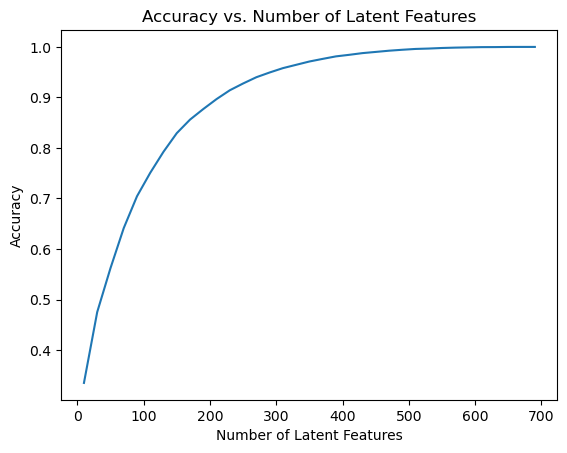

In [41]:
num_latent_feats = np.arange(10, 700 + 10, 20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)

    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)


plt.plot(num_latent_feats, 1 - np.array(sum_errs) / df.shape[0])
plt.xlabel("Number of Latent Features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Latent Features")


`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Instead, we might split our dataset into a training and test set of data, as shown in the cell below.

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below:

- How many users can we make predictions for in the test set?
- How many users are we not able to make predictions for because of the cold start problem?
- How many articles can we make predictions for in the test set?
- How many articles are we not able to make predictions for because of the cold start problem?


In [42]:
df_train = df.head(40000)
df_test = df.tail(5993)


In [43]:
def create_test_and_train_user_item(
    df_train: pd.DataFrame, df_test: pd.DataFrame, user_item: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame, Iterable[int], Iterable[int]]:
    """Split user_item matrix into train and test matrices. Also return test user IDs
        and article IDs.

    Args:
        df_train: raining dataframe
        df_test: test dataframe
        user_item: Matrix of users by articles: 1's when a user has interacted with an
            article, 0 otherwise

    Returns:
        A user-item matrix of the training dataframe (unique users for each row and
            unique articles for each column)
        A user-item matrix of the testing dataframe (unique users for each row and
            unique articles for each column)
        All of the test user ids
        All of the test article ids
    """
    # 1. Get train and test users and articles
    train_users, train_articles = (
        df_train["user_id"].drop_duplicates().tolist(),
        df_train["article_id"].drop_duplicates().tolist(),
    )
    test_users, test_articles = (
        df_test["user_id"].drop_duplicates().tolist(),
        df_test["article_id"].drop_duplicates().tolist(),
    )

    # 2. Split user_item matrix
    user_item_train = user_item.loc[train_users, train_articles]
    user_item_test = user_item.loc[test_users, test_articles]

    return user_item_train, user_item_test


In [44]:
user_item_train, user_item_test = create_test_and_train_user_item(
    df_train, df_test, user_item
)


In [45]:
# Replace the values in the dictionary below
a = 662  # len(user_item_test.index.difference(user_item_train.index))
b = 574  # user_item_test.shape[1]
c = 20  # len(user_item_test.index.intersection(user_item_train.index))
d = 0


sol_4_dict = {
    "How many users can we make predictions for in the test set?": c,
    "How many users in the test set are we not able to make predictions for because of the cold start problem?": a,
    "How many articles can we make predictions for in the test set?": b,
    "How many articles in the test set are we not able to make predictions for because of the cold start problem?": d,
}

t.sol_4_test(sol_4_dict)


Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.


In [46]:
u_train, s_train, vt_train = np.linalg.svd(user_item_train)


In [47]:
common_users = user_item_train.index.intersection(user_item_test.index)
common_articles = user_item_train.columns.intersection(user_item_test.columns)
common_users_train_idx = user_item_train.index.isin(common_users)
common_articles_train_idx = user_item_train.columns.isin(common_articles)


In [48]:
user_item_test_preds = user_item_test.loc[common_users, common_articles]


Text(0.5, 1.0, 'Accuracy vs. Number of Latent Features')

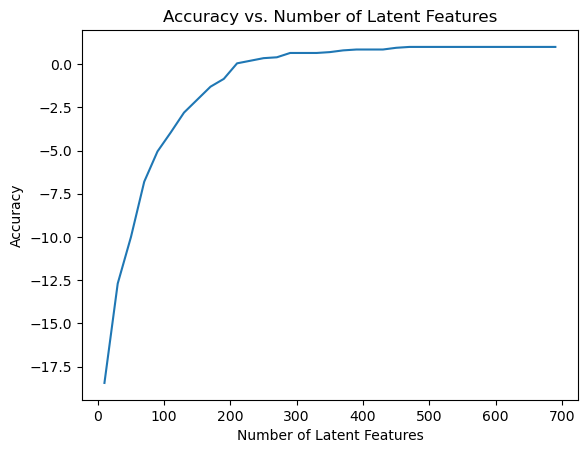

In [49]:
num_latent_feats = np.arange(10, 700 + 10, 20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]

    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))[
        np.ix_(common_users_train_idx, common_articles_train_idx)
    ]

    # compute error for each prediction to actual value
    diffs = np.subtract(
        user_item_test_preds,
        user_item_est,
    )

    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

plt.plot(num_latent_feats, 1 - np.array(sum_errs) / user_item_test_preds.shape[0])
plt.xlabel("Number of Latent Features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Latent Features")


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles?


In order to test whether a recommendation system works well in practice, I would use A/B testing. Groups of users could be randomly divided upon entering the IBM Watson Studio platform, each of them receiving recommendations from different recommendation systems (e.g. rank-based vs matrix factorization). After selecting the relevant metrics that IBM is interested in tracking (e.g. ratio of articles viewed per user), one can evaluate whether matrix factorization is a superior recommendation engine based on statistical and practical significance.


In [50]:
call(["python", "-m", "nbconvert", "Recommendations_with_IBM.ipynb", "--to", "html"])


[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to html
[NbConvertApp] Writing 806815 bytes to Recommendations_with_IBM.html


0